# Support Vector Machine
## Research Question: Predict police action following a stop and search

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv). Specifically, we will attempt to answer it by using Support Vector Machine to classify the data points on the target ("Outcome" of the stop and search).

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import util
import util_smote as usm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

from imblearn.over_sampling import SMOTE

One helper function to help with the evaluation process. Takes in the model, the X and y train/test, and ouputs:
- Accuracy on train and test
- Precision on train and test
- Recall on train and test
- F1 on train and test
- Matthews Correlation Coefficient on train and test
- COnfusion Matrix on test

In [2]:
police_actions_simple = ["Article Found", "Resolved", "Nothing",
                         "Cautioned", "Drug Warning", "Penalty Notice", "Arrested", "Summonsed"]

def evaluate(model, X_train, y_train, X_test, y_test, target_classes=police_actions_simple, average='weighted', binary=False, rotation=90, fontsize=18):
    print(f"Accurancy Score (Train): {int(np.around(model.score(X_train, y_train), 2) * 100)}%")
    print(f"Accuracy Score (Test): {int(np.around(model.score(X_test, y_test), 2) * 100)}%")
    y_train_predictions = model.predict(X_train)
    y_test_predictions = model.predict(X_test)
    print(f"\nPrecision Score (Train): {int(np.around(precision_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Precision Score (Test): {int(np.around(precision_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nRecall Score (Train): {int(np.around(recall_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Recall Score (Test): {int(np.around(recall_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nF1 Score (Train): {int(np.around(f1_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"F1 Score (Test): {int(np.around(f1_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nMCC (Train): {matthews_corrcoef(y_train, y_train_predictions)}")
    print(f"MCC (Test): {matthews_corrcoef(y_test, y_test_predictions)}")
    print("\n Confusion Matrix")
    if binary:
        util.confusion_plot(y_test=y_test, y_predictions=y_test_predictions, target_classes=["No Action", "Action"], rotation=rotation, fontsize=fontsize)
    else:
        util.confusion_plot(y_test=y_test, y_predictions=y_test_predictions, target_classes=target_classes, rotation=rotation, fontsize=fontsize)

## Cleaning the Data set

In [3]:
data = pd.read_csv("data.csv", low_memory = False)

data = util.data_cleaner(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Values

In [4]:
data_encoded, encoders = util.data_encoder(data)
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Split data into train and test

In [5]:
# Split into features and target
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)


# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

## Train the Support Vector Machine

The raw SVM takes too long to compute so I will apply preprocessing to normalise the features.

## Split the features in the range -1 to 1

In [6]:
#Process to normalise the data to [-1,1]
#Processing technique from: https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution

from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [7]:
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

Accurancy Score (Train): 65%
Accuracy Score (Test): 65%

Precision Score (Train): 43%
Precision Score (Test): 42%

Recall Score (Train): 65%
Recall Score (Test): 65%

F1 Score (Train): 52%
F1 Score (Test): 51%

MCC (Train): 0.0
MCC (Test): 0.0

 Confusion Matrix


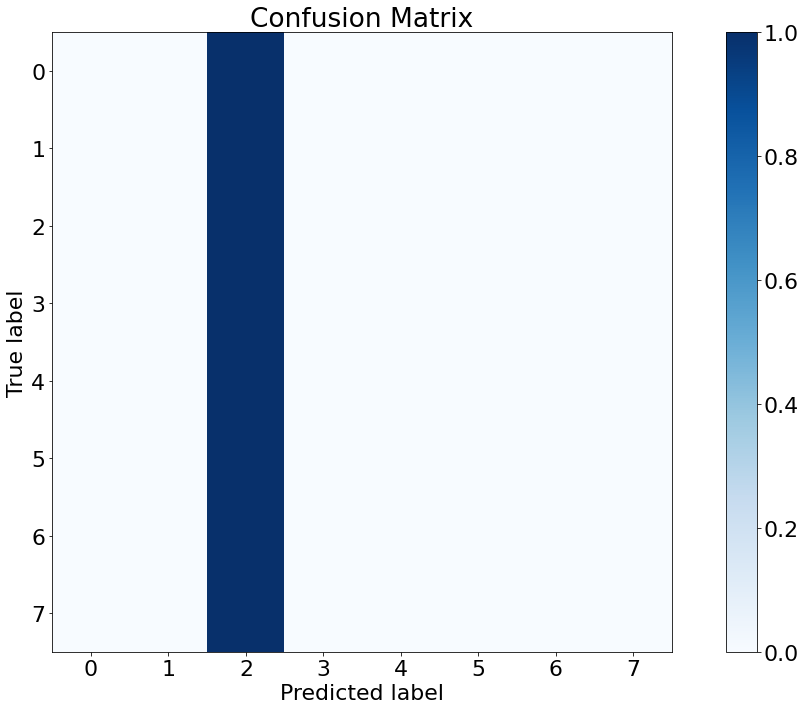

In [8]:
evaluate(model=svm, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

If the data is linearly inseperatable, then it is better to use a RBF kernel.

## Investigating different Kernels

In [9]:
svm = SVC(kernel = 'rbf')
svm.fit(X_train, y_train)

SVC()

Accurancy Score (Train): 66%
Accuracy Score (Test): 65%

Precision Score (Train): 55%
Precision Score (Test): 51%

Recall Score (Train): 66%
Recall Score (Test): 65%

F1 Score (Train): 52%
F1 Score (Test): 51%

MCC (Train): 0.020169707959239745
MCC (Test): 0.0052853371490062815

 Confusion Matrix


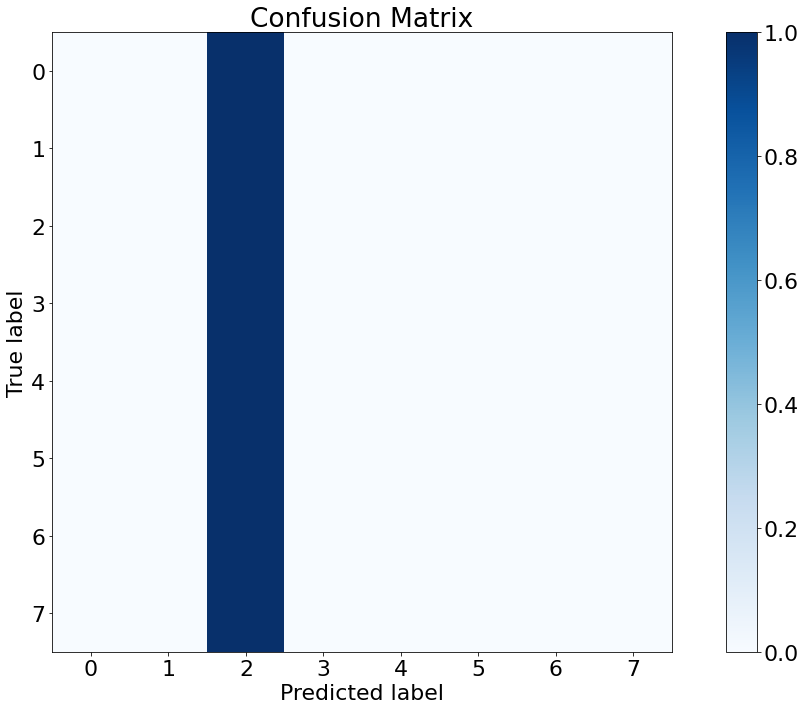

In [10]:
evaluate(model=svm, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

This only yielded a marginally better training score.

## Split target into "Police Action" (1) and "No Action" (0)

I will try to repeat the above process, but instead of the target being split into eight classes, I split it into two: either there was police action after the stop and search, or there wasn't. I hypothesize that combining all the minority classes into a single class, will help alleviate the imbalance, even if it comes at the cost of losing information from the dataset (i.e. instead of know what specific action the police officer took after the stop and search, we would only know that some action took place).

In [11]:
#Replace all values in Outcome column, with 0 if "Nothing found - no further action", else 1.
# Reference for dictionary idea to replace values: https://stackoverflow.com/questions/17114904/python-pandas-replacing-strings-in-dataframe-with-numbers
outcome_splitter = {
    "Nothing found - no further action": 0, 
    "Article found - Detailed outcome unavailable": 1, 
    "Local resolution": 1,
    "Offender cautioned": 1,
    "Offender given drugs possession warning": 1,
    "Offender given penalty notice": 1,
    "Suspect arrested": 1,
    "Suspect summonsed to court": 1
    }
data_binary = data.applymap(lambda s: outcome_splitter.get(s) if s in outcome_splitter else s)
data_binary.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,Person search,2015-03-02 16:40:00+00:00,51.512286,-0.114491,Male,25-34,Asian,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
1,Person search,2015-03-02 16:40:00+00:00,51.512286,-0.114491,Male,25-34,Asian,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
2,Person search,2015-03-02 18:45:00+00:00,51.512286,-0.114491,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
4,Person and Vehicle search,2015-03-03 15:50:00+00:00,51.512286,-0.114491,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
5,Person search,2015-03-03 20:20:00+00:00,51.512286,-0.114491,Male,25-34,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,0


In [12]:
data_binary_encoded, encoders_binary = util.data_encoder(data_binary)

print(encoders_binary)
data_binary_encoded.head()

{'Type Encoder': LabelEncoder(), 'Gender Encoder': LabelEncoder(), 'Age range Encoder': LabelEncoder(), 'Officer-defined ethnicity Encoder': LabelEncoder(), 'Legislation Encoder': LabelEncoder(), 'Object of search Encoder': LabelEncoder(), 'Outcome Encoder': LabelEncoder(), 'Date Encoder': LabelEncoder()}


,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,1
1,1,0,51.512286,-0.114491,1,1,0,4,8,1
2,1,1,51.512286,-0.114491,1,1,4,4,8,1
4,0,2,51.512286,-0.114491,1,1,4,4,8,1
5,1,3,51.512286,-0.114491,1,1,0,3,3,0


In [13]:
# Split into features and target
target_binary = data_binary_encoded["Outcome"]
features_binary = data_binary_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(features_binary, target_binary, test_size=0.2, random_state=10)

#Process to normalise the data to [-1,1]
#Processing technique from: https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution
X_train_binary = preprocessing.scale(X_train_binary)
X_test_binary = preprocessing.scale(X_test_binary)

In [14]:
svm_binary = SVC(kernel = 'linear')
svm_binary.fit(X_train_binary, y_train_binary) 

SVC(kernel='linear')

Accurancy Score (Train): 0%
Accuracy Score (Test): 0%

Precision Score (Train): 0%
Precision Score (Test): 0%

Recall Score (Train): 0%
Recall Score (Test): 0%

F1 Score (Train): 0%
F1 Score (Test): 0%

MCC (Train): 0.0
MCC (Test): 0.0

 Confusion Matrix


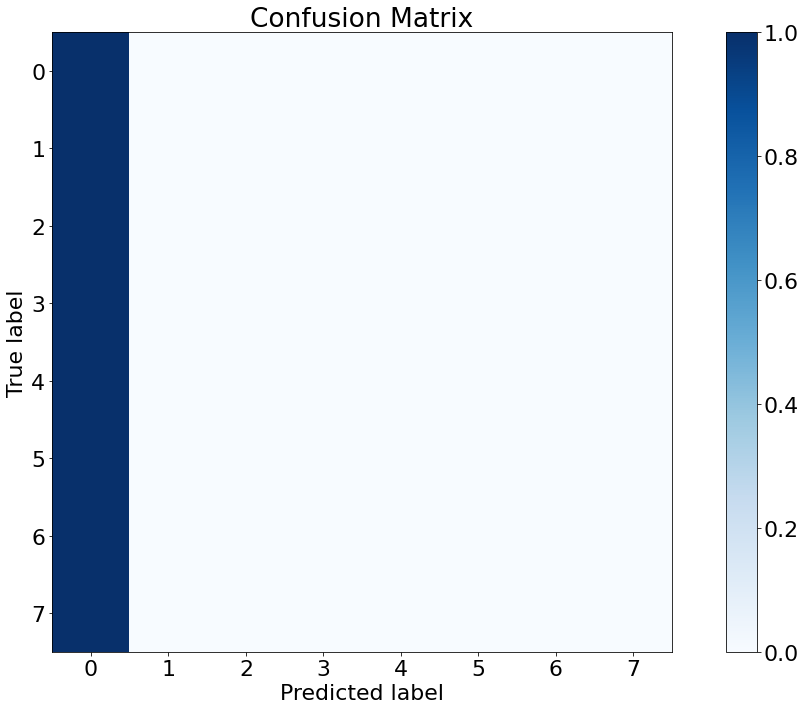

In [15]:
evaluate(model=svm_binary, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

It appears the SVM is only predicting No Action as its outcome, perhaps using SMOTE will improve the results.

## Using SMOTE
We try oversampling the minority classes using SMOTE (Synthetic Minority Oversampling Technique). This will generate artificial data until each class reaches a specified frequency.

We use the functions in util_smote.py librry, which in turn makes use of functions found in the Imbalance-learn library.

For the first oversampling, we will add aritficial samples to the minority classes until they each have a frequency equal to that of the majority class.

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


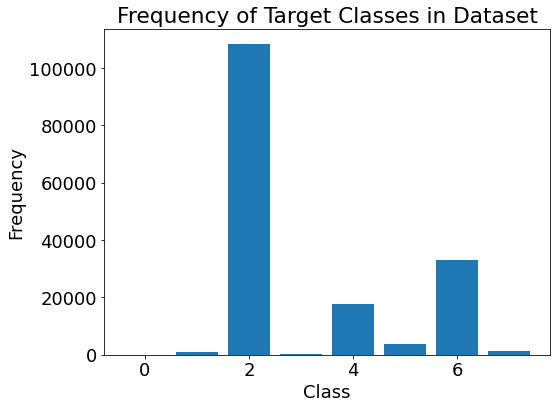

In [16]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"], figsize=(8,6))

Class 0: 0.02%     (32)
Class 1: 0.67%     (891)
Class 2: 65.49%     (86784)
Class 3: 0.1%     (131)
Class 4: 10.74%     (14229)
Class 5: 2.27%     (3014)
Class 6: 19.95%     (26436)
Class 7: 0.76%     (1003)
Total: 132520


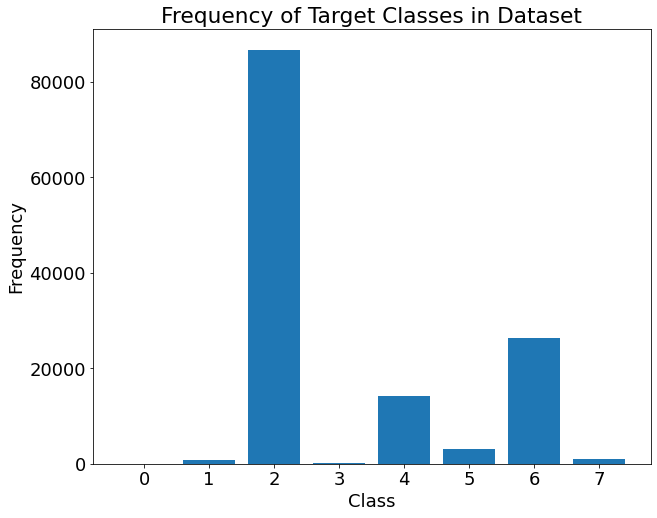

In [17]:
#Train/test split data_encoded
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

usm.display_frequencies(y_train)

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


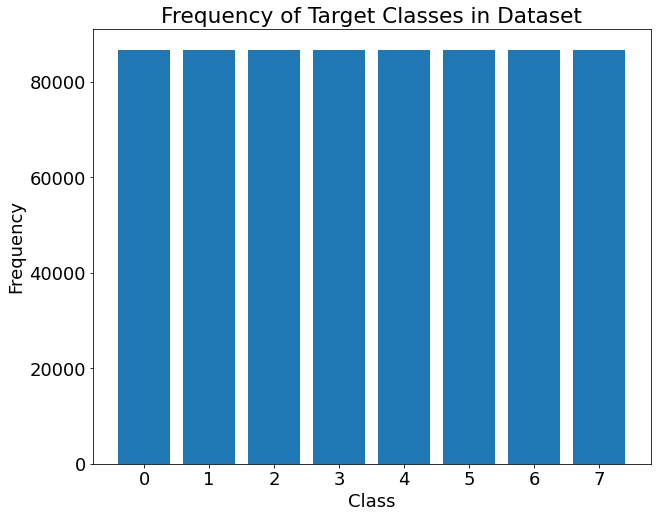

In [18]:
X_smote, y_smote = usm.smote_data(X_train, y_train)
usm.display_frequencies(y_smote)

WARNING: this cell takes signficant time to execute - never executed for us

In [19]:
svm_smote = SVC(kernel = 'linear')
svm_smote.fit(X_smote, y_smote)

SyntaxError: invalid syntax (<ipython-input-19-3033bd8da7d8>, line 1)

In [ ]:
evaluate(model=svm_smote, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

# Using Biased SMOTE (to majority class)
We over sample minority classes, but not to an extent that equalizes them to the majority class

In [ ]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [ ]:
svm_smote = SVC(kernel = 'linear')
svm_smote.fit(X_smote, y_smote)

In [ ]:
evaluate(model=svm_smote, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

## Using Biased SMOTE (to minority class)

In [ ]:
sampling_strategy = {0:160000, 1:160000, 2:86784, 3:160000, 4:140000, 5:150000, 6:130000, 7:160000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [ ]:
svm_smote = SVC(kernel = 'linear')
svm_smote.fit(X_smote, y_smote)

In [ ]:
evaluate(model=svm_smote, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

## Using Grid Search to Tune Hyperparamaters

In [ ]:
X_smote, y_smote = usm.smote_data(X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
svm_param = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear', 'rbf']}
svm_search = GridSearchCV(SVC(), svm_param, verbose=1, cv=3, scoring="precision_weighted", n_jobs=-1)
svm_search.fit(X_smote, y_smote)

In [ ]:
evaluate(model=svm_search.best_estimator_, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

In [ ]:
print(svm_search.best_params_)